## <p style="text-align: center;">B9AI103_2122_TMD3_CA_1</p>
### <p style="text-align: center;"> Details </p>
#### <p style="text-align: center;">Name: Sunil Judhistira Gauda</p>
#### <p style="text-align: center;">Student ID : 10595858 </p>

## Hybrid Movie Recommendation using Movie Lense Large Data set

Note : 
* Running cosine similarity might take some computaion and time

### Imports
1. numpy, pandas - for numeric computation and data management
2. scikit learn - for TFIDF Vectorising and cosine similarity
3. surprise - scikit learn extension to work on rating based data
    * surprise may or may not install directly depending on OS, below is the direct way of downloading and installing scikit-surprise
    * Installation Instructions
        * pip install numpy cython
        * git clone https://github.com/NicolasHug/surprise.git
        * cd surprise
        * python setup.py install
4. wordcloud - represent word density
5. itertools - create a combination to work with

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Reader, Dataset, SVD
from surprise.model_selection import KFold
from surprise.model_selection.validation import cross_validate
import matplotlib.pyplot as plt
from  wordcloud import WordCloud
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity


### Importing the data
* Data we require are as follows
    * Meta-Data like **Genre** for **content based** filtering
    * User Data like **Ratings** for **collaberative** filtering
* **Hybrid** recommendation will be the combination of **content and collaberative** filtering

Note : 
Use the following link for smaller data set as the large dataset can fail on calculateing cosine simliarity with less memory
* https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
* **update the path of the data**
* **use_large** should be **False**

In [2]:
use_large = False
if use_large:
    movies = pd.read_csv("../../../../DataSets/ml-latest/movies.csv")
    ratings = pd.read_csv("../../../../DataSets/ml-latest/ratings.csv")
    tags = pd.read_csv("../../../../DataSets/ml-latest/tags.csv")
    links = pd.read_csv("../../../../DataSets/ml-latest/links.csv")
else :
    movies = pd.read_csv("../../../../DataSets/ml-latest-small/movies.csv")
    ratings = pd.read_csv("../../../../DataSets/ml-latest-small/ratings.csv")
    tags = pd.read_csv("../../../../DataSets/ml-latest-small/tags.csv")
    links = pd.read_csv("../../../../DataSets/ml-latest-small/links.csv")

### Exploratory Analysis of the Data
Steps inncluded for Data Analysis includes
* Data Preparation
* Data Exploration
* Data Visualisation

#### Data Preparation

##### Seperating **Year** from the **Titile** of the movie
* As the data we have merged the title of the movie with the date it was released we dont have any seperate data for year of release
* Using few techniques below we will seperate date from the title and convert date into int and title into string

In [3]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)
movies['year'] = movies['year'].str.extract('(\d+)', expand=False)
movies.dropna(inplace=True)
movies['year'] = movies['year'].astype(int)
movies['title'] = movies['title'].replace(r'\([^)]*\)', '', regex=True).str.lower()
movies['title'] = movies['title'].str.rstrip()
movies['title'] = movies['title'].str.lstrip()
movies['title'] = movies['title'].astype("string")
movies.head()

,movieId,title,genres,year
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji,Adventure|Children|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama|Romance,1995
4,5,father of the bride part ii,Comedy,1995


##### Preparing the final DataFrame
Final Data Frame contains all the data required for exploratory analysis of the data and visualise the data using various techniques.

In [4]:
# Preparing the Data frame by combining all necessary columns from other dataframes
movies_final_df = movies
movies_final_df["userid"] = ratings["userId"]
movies_final_df["rating"] = ratings["rating"]
movies_final_df["timestamp"] = ratings["timestamp"]
movies_final_df["tag"] = tags["tag"]
movies_final_df["tmdbId"] = links["tmdbId"]


##### Dropping the NA columns
As we have a huge amount of data, and the NA counts for tags only, that is also few hundread of the entire dataset we can get rid of NA rows.

In [5]:
movies_final_df.dropna(inplace=True)
movies_final_df.isna().sum()

movieId      0
title        0
genres       0
year         0
userid       0
rating       0
timestamp    0
tag          0
tmdbId       0
dtype: int64

#### Data Exploration

**Sample of our final data set**

In [6]:
movies_final_df.head()


,movieId,title,genres,year,userid,rating,timestamp,tag,tmdbId
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,964982703,funny,862.0
1,2,jumanji,Adventure|Children|Fantasy,1995,1,4.0,964981247,Highly quotable,8844.0
2,3,grumpier old men,Comedy|Romance,1995,1,4.0,964982224,will ferrell,15602.0
3,4,waiting to exhale,Comedy|Drama|Romance,1995,1,5.0,964983815,Boxing story,31357.0
4,5,father of the bride part ii,Comedy,1995,1,5.0,964982931,MMA,11862.0


**Shape of the Data**

In [7]:
movies_final_df.shape

(3679, 9)

**Data Description**

In [8]:
movies_final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3679 entries, 0 to 3682
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    3679 non-null   int64  
 1   title      3679 non-null   string 
 2   genres     3679 non-null   object 
 3   year       3679 non-null   int32  
 4   userid     3679 non-null   int64  
 5   rating     3679 non-null   float64
 6   timestamp  3679 non-null   int64  
 7   tag        3679 non-null   object 
 8   tmdbId     3679 non-null   float64
dtypes: float64(2), int32(1), int64(3), object(2), string(1)
memory usage: 273.1+ KB


##### Listing the top 10 rated movies

In [9]:
movies_final_df[['title', 'rating']].sort_values(
    'rating', ascending=False).head(10)


,title,rating
1841,virus,5.0
421,lassie,5.0
3070,ishtar,5.0
3066,hiding out,5.0
3064,gardens of stone,5.0
1466,child's play,5.0
419,kalifornia,5.0
3057,cop,5.0
1467,child's play 2,5.0
407,"house of the spirits, the",5.0


#### Data Visualization

##### Movies released per year
By plotting movies angainst the year of release we can clearly see that by the year 1980 - 2000 the release was at peak, i.e maximum movies were released that year as per our data set.

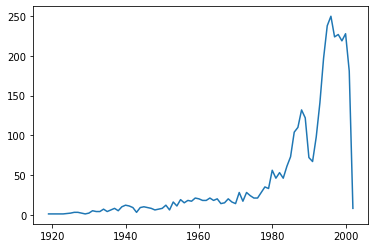

Maximum Number of Movies Relesed = 250
year = 1996


count     82.000000
mean      44.865854
std       66.135245
min        1.000000
25%        7.250000
50%       17.000000
75%       46.000000
max      250.000000
Name: title, dtype: float64

In [10]:
plt.plot(movies_final_df.groupby('year').title.count())
plt.show()

a = movies_final_df.groupby('year').title.count()

print('Maximum Number of Movies Relesed =', a.max())
for i in a.index:
    if a[i] == a.max():
        print('year =', i)
a.describe()


##### Exploring Genre's

In [11]:
popular_genre = (movies_final_df.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
popular_genre.head(10)


Drama        1720
Comedy       1374
Thriller      687
Romance       669
Action        597
Adventure     445
Crime         411
Horror        350
Sci-Fi        322
Children      275
Name: genres, dtype: int64

**Drama**, **Romance**, **Comedy** are the most focused genre

(-0.5, 999.5, 399.5, -0.5)

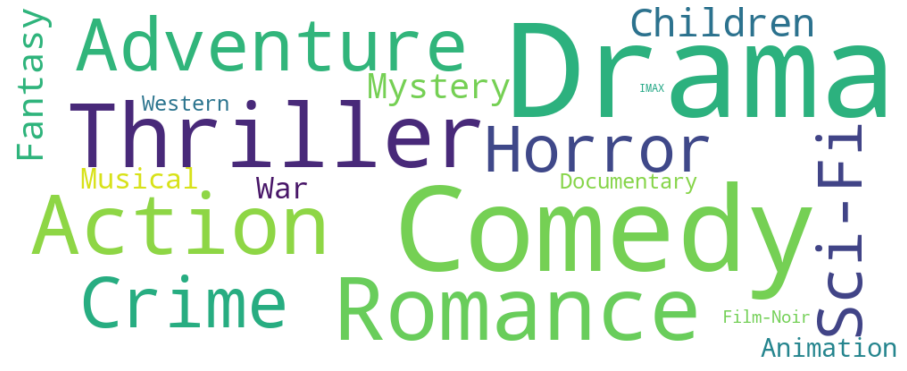

In [12]:
word_cloud_genre = WordCloud(width=1000,height=400,background_color='white')
word_cloud_genre.generate_from_frequencies(popular_genre.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(word_cloud_genre, interpolation="bilinear")
plt.axis('off')

#### Content Based Filtering
There are two types of filtering in content based movie recommendation
1. Description Based - Based on textual description of the movie or the taglines/punchlines
2. **Meta data based** - Genre, Keywords etc <br />
    * **As we only have metadata of the movies, we will work with Meta Data based filtering**

##### TFIDF

1. Using TFIDF Vetorising we will check the frequency of **genre** in our data
2. Appling TFIDF we get a matrix representaion of the frequency of the keywords


In [13]:
tfidf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                     for c in combinations(s.split('|'), r=i)))
tfidf_mat = tfidf.fit_transform(movies['genres'])
tfidf_mat.shape


(3679, 538)

**Cosine Similarity**
Using Cosine Similarity we can find the closeness between the movie genre, as we dont need to consider the size of the data to estimate the genre, genre is independent of meaning depending on where its placed in our data, genre in any movie assignes same meaning to the data.

In [14]:
cosine_sim = cosine_similarity(tfidf_mat)

##### Creating an Index of the movies by title to help us get the list of data while predicting.

In [15]:
movie_indices = pd.Series(movies_final_df.index, index=movies_final_df['title']).drop_duplicates()

In [16]:
movies_final_df.head()
movie_indices


title
toy story                         0
jumanji                           1
grumpier old men                  2
waiting to exhale                 3
father of the bride part ii       4
                               ... 
walk to remember, a            3678
beijing bicycle                3679
escaflowne: the movie          3680
maelström                      3681
metropolis                     3682
Length: 3679, dtype: int64

#### Recommend using Content Based Filtering by Meta Data
To recommend based on Meta Data / Content of the movie we require the following.
* Title - Title is the key of **Index** we have created to fetch data.
* Cosine Similarity - It will help us get the titles that are close to the genre of the Movie title we provide

In [17]:
# Recommend Method
def recommend_movies(title, cosine_sim = cosine_sim) :
    # Get the movie we out of index using the title provided
    m_id = movie_indices[title]

    # Find Movies with similar index to the title provided
    sim_scores = list(enumerate(cosine_sim[m_id]))

    # Sort the data as per the similarty of the title
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)

    # Fetch the Top 15 of the Data which has similar score
    sim_scores = sim_scores[1:16]

    # Create the list of indexs after removing duplicates to sort movie data
    f_movie_indices = [i[0] for i in sim_scores]

    # Removing outliers or movies with lower rating
    for i in f_movie_indices:
        pop = movies_final_df.at[i, 'rating']
        if pop<5 or pop>10:
            f_movie_indices.remove(i)

    return movies_final_df[["title", "rating"]].iloc[f_movie_indices]


##### Checking the Content based recommendation function

In [18]:

recommend_movies('toy story')


,title,rating
2355,toy story 2,2.0
3000,"emperor's new groove, the",2.5
1505,"black cauldron, the",3.0
2539,we're back! a dinosaur's story,3.0
3336,"land before time, the",4.5
1757,"bug's life, a",4.5
3194,shrek,4.5


#### Collaberative Filtering
1. Content Based Filtering is limited by recommendations based on types of genre that are close to each other, it does not consider any aspects of user prefrence and customised user recommendation
2. Collaberative filtering we use user specific data and SVD to minimise RMSE and provide recommendations to what a user is personally interested in.

**Tools Used**
For implemneting collaberative filtering over our data, we use scikit-surprise that is a library built upon scikit learn and provides great tools like Reader, SVD to compute and manage the data.

In [19]:
# Reader is used to parse rating based data
reader = Reader()

# Using Reader to parse user specific Rating based data
u_df = Dataset.load_from_df(ratings[['userId', 'rating', 'movieId']], reader)

# Generalising data using Kfold
kf = KFold(n_splits=5)
kf.split(u_df)

<generator object KFold.split at 0x000001CA2270A2D0>

##### Using SVD - Single Value Decomposition to Reduce the RMSE over the data that has beed Generalised using KFlod and fitting the training set to it.

In [20]:
# SVD Object
svd = SVD()

# Crossvalidating against our dataset for RMSE reduction
cross_validate(svd, u_df, measures=['RMSE', 'MAE'])

# Fetching the training set
trainset = u_df.build_full_trainset()

# Fitting the Traing set to SVD
svd.fit(trainset)


##### Preparing Movie Data to be used for estimating movies using Hybrid Method of estimation

In [21]:
cols = np.array(links['tmdbId'], np.int64)

links['tmdbId'] = cols

# Merge movies_metadata.csv and links_small.csv files
links = links.merge(
    movies_final_df[['title', 'tmdbId']], on='tmdbId').set_index('title')
links_index = links.set_index('tmdbId')


##### Hybrid Recommendation Function
1. Content Based
    * The function below uses cosine similarity to fetch the closeness by genre
    * Sorts the data as per cosine similarity scores
    * Fetching the top 30 of the data
    * Creates a list of **Movie Indexes** using the Cosine Similarity Score
2. Collaberative Filtering
    * Using our Movies Data frame to fetch necessary columns, with the **Movie Indexes** data.
    * Estimating Movies as per the list of moves by collaberative filtering with SVD Predict Function, by using the Content Based List.
    * Returing the top 15 estimated data

In [24]:
# Hybrid recommendation Function
def hybrid(userId, title):

    # find the movie ID using the title
    m_id = movie_indices[title]

    # extract similarity scores
    sim_scores = list(enumerate(cosine_sim[m_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]  # Scores of the 30 most similar movies

    # Get movie indexes of the score
    f_movie_indices = [i[0] for i in sim_scores]

    # Extract the movie data from our movie DF
    movies = movies_final_df.iloc[f_movie_indices][['title','rating','tmdbId']]
    
    # Predict the movies
    movies['est'] = movies['tmdbId'].apply(lambda x: svd.predict(
        userId, links_index.loc[x]['movieId']).est)

    # Rank movies according to the predicted values
    movies = movies.sort_values('est', ascending=False)
    movies.columns = ['Title' , 'Rating',
                      'TMDb Id', 'Estimated Prediction']
                      
    return movies.head(15)  # Display top 15 similar movies


In [25]:
hybrid(1, 'jumanji')


,Title,Rating,TMDb Id,Estimated Prediction
53,"indian in the cupboard, the",5.0,11359.0,5
109,"neverending story iii, the",4.0,27793.0,5
635,alaska,3.0,36344.0,5
580,flipper,3.0,36355.0,5
521,homeward bound ii: lost in san francisco,4.0,25059.0,5
421,lassie,5.0,29918.0,5
204,far from home: the adventures of yellow dog,4.0,27985.0,5
131,casper,4.0,8839.0,5
119,"amazing panda adventure, the",4.0,30765.0,5
7,tom and huck,4.0,45325.0,5
